In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
import numpy as np
import rasterio

from keras.layers import Conv2D,BatchNormalization,Activation,MaxPool2D,Conv2DTranspose,Concatenate,Input
from keras.models import Model

from keras import metrics
import tensorflow as tf
from tensorflow.keras import backend as K
import os
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from keras.metrics import Recall,Precision
from tensorflow.keras.optimizers import Adam
import cv2
from keras.callbacks import EarlyStopping,ModelCheckpoint,CSVLogger,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import random
tf.config.run_functions_eagerly(True)
from skimage.metrics import structural_similarity as ssim

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# x_test_1D_read=np.loadtxt('/content/drive/MyDrive/data_capstone/x_test.csv',delimiter=',')
x_train_1D_read=np.loadtxt('/content/drive/MyDrive/data_capstone/x_train.csv',delimiter=',')
# y_test_1D_read=np.loadtxt('/content/drive/MyDrive/data_capstone/y_test.csv',delimiter=',')
y_train_1D_read=np.loadtxt('/content/drive/MyDrive/data_capstone/y_train.csv',delimiter=',')

In [ ]:
x_train=tf.cast(np.reshape(x_train_1D_read,(1500,200,200,7)),tf.float32)[:500,:,:,:]
y_train=tf.cast(np.reshape(y_train_1D_read,(1500,200,200,4)),tf.float32)[:500,:,:,:]
# x_test=tf.cast(np.reshape(x_test_1D_read,(350,200,200,7)),tf.float32)
# y_test=tf.cast(np.reshape(y_test_1D_read,(350,200,200,4)),tf.float32)

In [ ]:
x_test_1D_read=np.loadtxt('/content/drive/MyDrive/data_capstone/x_test.csv',delimiter=',')
y_test_1D_read=np.loadtxt('/content/drive/MyDrive/data_capstone/y_test.csv',delimiter=',')
x_test=tf.cast(np.reshape(x_test_1D_read,(350,200,200,7)),tf.float32)
y_test=tf.cast(np.reshape(y_test_1D_read,(350,200,200,4)),tf.float32)

In [ ]:
x_test=tf.cast(np.reshape(x_test_1D_read,(350,200,200,7)),tf.float32)[:100,:,:,:]
y_test=tf.cast(np.reshape(y_test_1D_read,(350,200,200,4)),tf.float32)[:100,:,:,:]

In [ ]:
checkpoint_path = "/content/drive/MyDrive/data_capstone/training_1/cp-{epoch:04d}.cpkt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose = 1)

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def ss(y_pred,y_true):
  # y_pred=tf.math.argmax(y_pred,axis=2)+1
  # y_true=tf.math.argmax(y_true,axis=2)+1
  return 1-ssim(y_pred.numpy(),y_true.numpy(),data_range=4)

In [ ]:
def conv(input,no):
  layer=Conv2D(no,3,padding='same')(input)
  norm=BatchNormalization()(layer)
  act=Activation('relu')(norm)

  layer2=Conv2D(no,3,padding='same')(act)
  norm2=BatchNormalization()(layer2)
  act2=Activation('relu')(norm2)

  return act2
#conv block serves as a common block to both the upscaling and downscaling part the architecture

In [ ]:
def down_scale(input,no):
  convolution_layer=conv(input,no)
  pooling=MaxPool2D(pool_size=(1,1))(convolution_layer)
  return convolution_layer,pooling   
 # we return both the conv output and the pooling output so that as to
# enable the skip connections and the proceed with the down scaling 

In [ ]:
def up_scale(input,skip_connections,no):
  up_scaling=Conv2DTranspose(no,kernel_size=(3,3),strides=1,padding='same')(input)
# stride = 2 implies that the size of the image ie both the height and the weight of the image is doubled 
  conc=Concatenate()([up_scaling,skip_connections])
  convol=conv(conc,no)
  return convol

In [ ]:
def UNET(input_img):
  inputs=Input(input_img)
  skip_conn1,down1=down_scale(inputs,64)
  skip_conn2,down2=down_scale(down1,128)
  skip_conn3,down3=down_scale(down2,256)
  skip_conn4,down4=down_scale(down3,256)
  skip_conn5,down5=down_scale(down4,512)
  skip_conn6,down6=down_scale(down5,512)
  skip_conn7,down7=down_scale(down6,512)
  skip_conn8,down8=down_scale(down7,512)
  bridge=conv(down8,1024)

  up1=up_scale(bridge,skip_conn8,512)
  up2=up_scale(up1,skip_conn7,512)
  up3=up_scale(up2,skip_conn6,512)
  up4=up_scale(up3,skip_conn5,512)
  up5=up_scale(up4,skip_conn4,256)
  up6=up_scale(up5,skip_conn3,256)
  up7=up_scale(up6,skip_conn2,128)
  up8=up_scale(up7,skip_conn1,64 )

  output_layer=Conv2D(4,1,padding='same',activation='sigmoid')(up8)
#only one filter is required as we are doing binary segmentation and activation layer is sigmoid 
#as our mask contains only pixel values between 0 and 1 
  return Model(inputs,output_layer,name="U-NET")

In [ ]:
input_shape=(200,200,7)
model=UNET(input_shape)

In [ ]:
model.compile(loss=dice_loss,optimizer=Adam(),metrics=[dice_coef,iou,Recall(),Precision(),tf.keras.metrics.Accuracy()])

In [ ]:
model.fit(x = x_train,y = y_train,epochs=10,batch_size=1, callbacks=[cp_callback])

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


500/500 [==============================] - ETA: 0s - loss: 0.3109 - dice_coef: 0.6891 - iou: 0.5329 - recall_1: 0.7808 - precision_1: 0.6816 - accuracy: 0.0024
Epoch 1: saving model to /content/drive/MyDrive/data_capstone/training_1/cp-0001.cpkt
500/500 [==============================] - 1847s 4s/step - loss: 0.3109 - dice_coef: 0.6891 - iou: 0.5329 - recall_1: 0.7808 - precision_1: 0.6816 - accuracy: 0.0024
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.2347 - dice_coef: 0.7653 - iou: 0.6251 - recall_1: 0.7853 - precision_1: 0.7569 - accuracy: 0.0082
Epoch 2: saving model to /content/drive/MyDrive/data_capstone/training_1/cp-0002.cpkt
500/500 [==============================] - 1815s 4s/step - loss: 0.2347 - dice_coef: 0.7653 - iou: 0.6251 - recall_1: 0.7853 - precision_1: 0.7569 - accuracy: 0.0082
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.2309 - dice_coef: 0.7691 - iou: 0.6306 - recall_1: 0.7884 - precision_1: 0.7555 - accuracy: 0

In [ ]:
weights_path = "/content/drive/MyDrive/data_capstone/training_1/cp-0006.cpkt"

In [ ]:
model.load_weights(weights_path)

In [ ]:
pred=model.predict(x_test, batch_size=1)

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


10/10 [==============================] - 33s 1s/step


In [ ]:
y_pred=tf.math.argmax(pred,axis=3)
y_test_cond=tf.math.argmax(y_test,axis=3)

In [ ]:
l=list()
for i in range(10):
  l.append(ss(y_pred,y_test_cond))
sum(l)/len(l)

0.19418995374365364

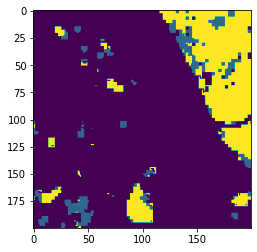

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(y_pred[1])

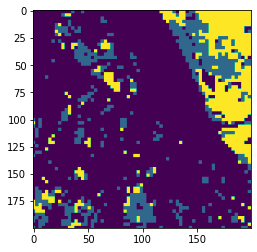

In [ ]:
plt.imshow(y_test_cond[1])